In [1]:
import numpy as np
from sklearn.externals import joblib
import copy
import random
import math
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import metrics
import mpld3
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

In [3]:
#mp.rcParams.update({'font.size': 16})

In [4]:
datadict = joblib.load("Two_Port_Standard_Dictionary_Cleaned_Interpolated.pkl")

In [5]:
num_fake_points = 15000
magS21_deviation = 0.0001
frequency_range = np.linspace(2,18,50)

In [6]:
def make_fake_lines(variable,num_lines,starting_deviation,slope_deviation,x_axis,smooth_frac):
    dataset_lines = []
    for iteration in range(num_lines):
        new_dataset = copy.deepcopy(datadict['CTN210']['System 2,7'][random.choice(datadict['CTN210']['System 2,7'].keys())][variable])
        magS11_points = []
        first_point = new_dataset[0] + np.random.normal(0,starting_deviation)
        magS11_points.append(first_point)
        delta_x = x_axis[1]-x_axis[0]
        for index in range(len(new_dataset)-1):
            delta_y = new_dataset[index+1]-new_dataset[index]
            segment_slope = delta_y / delta_x
            segment_slope += np.random.normal(0,slope_deviation)
            new_point_y_val = magS11_points[index] + (delta_x * segment_slope)
            magS11_points.append(new_point_y_val)
        new_magS11_points = lowess(magS11_points, x_axis, is_sorted=True, frac=smooth_frac, it=0)[:,1]
        dataset_lines.append(new_magS11_points)
    return dataset_lines

In [7]:
magS21_arr = np.array(make_fake_lines("magS21",num_fake_points,0.0003,0.00024,frequency_range,0.08))

In [8]:
def get_trained_classifier(randomness_amplitude,untrained_classifier):
    incorrect_magS21_data = copy.deepcopy(magS21_arr)
    for i in range(len(incorrect_magS21_data)):
        incorrect_magS21_data[i] = (incorrect_magS21_data[i] + np.random.normal(0,randomness_amplitude,50))
    #Making training and test data
    S21_training_data = []
    S21_training_data.extend(incorrect_magS21_data.tolist())
    S21_training_data.extend(magS21_arr.tolist())
    S21_training_data_arr = np.array(S21_training_data)
    targets = ["Bad","Good"]
    S21_target_arr = np.repeat(targets,len(magS21_arr))
    S21_training_data_arr,S21_target_arr = shuffle(S21_training_data_arr,S21_target_arr, random_state=0)
    #Cloning and Training Classifier
    clf = clone(untrained_classifier)
    clf.fit(S21_training_data_arr,S21_target_arr)
    return clf

In [9]:
def get_average_probability(randomness_amplitude,trained_classifier,num_return_lines):
    test_data = copy.deepcopy(magS21_arr)
    for i in range(len(test_data)):
        test_data[i] = test_data[i] + np.random.normal(0,randomness_amplitude,50)
    probabilities = trained_classifier.predict_proba(test_data)
    predictions = trained_classifier.predict(test_data)
    formatted_probabilities = []
    for index in range(len(probabilities)):
        if predictions[index] == "Bad":
            new_prob = 0.5-(0.5*probabilities[index])
            formatted_probabilities.append(new_prob[0])
        else:
            new_prob = 0.5+(0.5*probabilities[index])
            formatted_probabilities.append(new_prob[0])
    return (formatted_probabilities[:num_return_lines],test_data[:num_return_lines])

In [10]:
randomness_amp = 0.001
num_test_amplitudes = 50
test_amplitude_min = 0
test_amplitude_max = 0.0015
training_randomness_amplitude = 0.0001

In [11]:
trained_classifier = get_trained_classifier(training_randomness_amplitude,RandomForestClassifier())
testing_amplitudes = np.linspace(test_amplitude_min,test_amplitude_max,num_test_amplitudes)
probabilities = []
results = []
print "Testing Progress: ",
for amp in testing_amplitudes:
    prob,result = get_average_probability(amp,trained_classifier,15)
    temporary_prob = np.array(prob)-np.array(prob).min()
    prob_made_better = 1-((temporary_prob)/temporary_prob.max())
    probabilities.extend(prob_made_better)
    results.extend(result)
    print "\b#",
print "\nComplete!"

Testing Progress: ################################################## 
Complete!


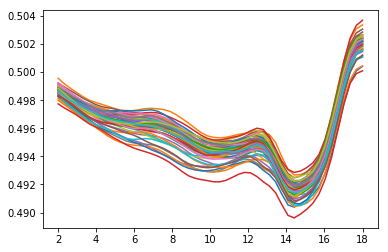

In [12]:
for i in range(50):
    plt.plot(frequency_range,magS21_arr[i])
plt.show()

Graphing Progress: 

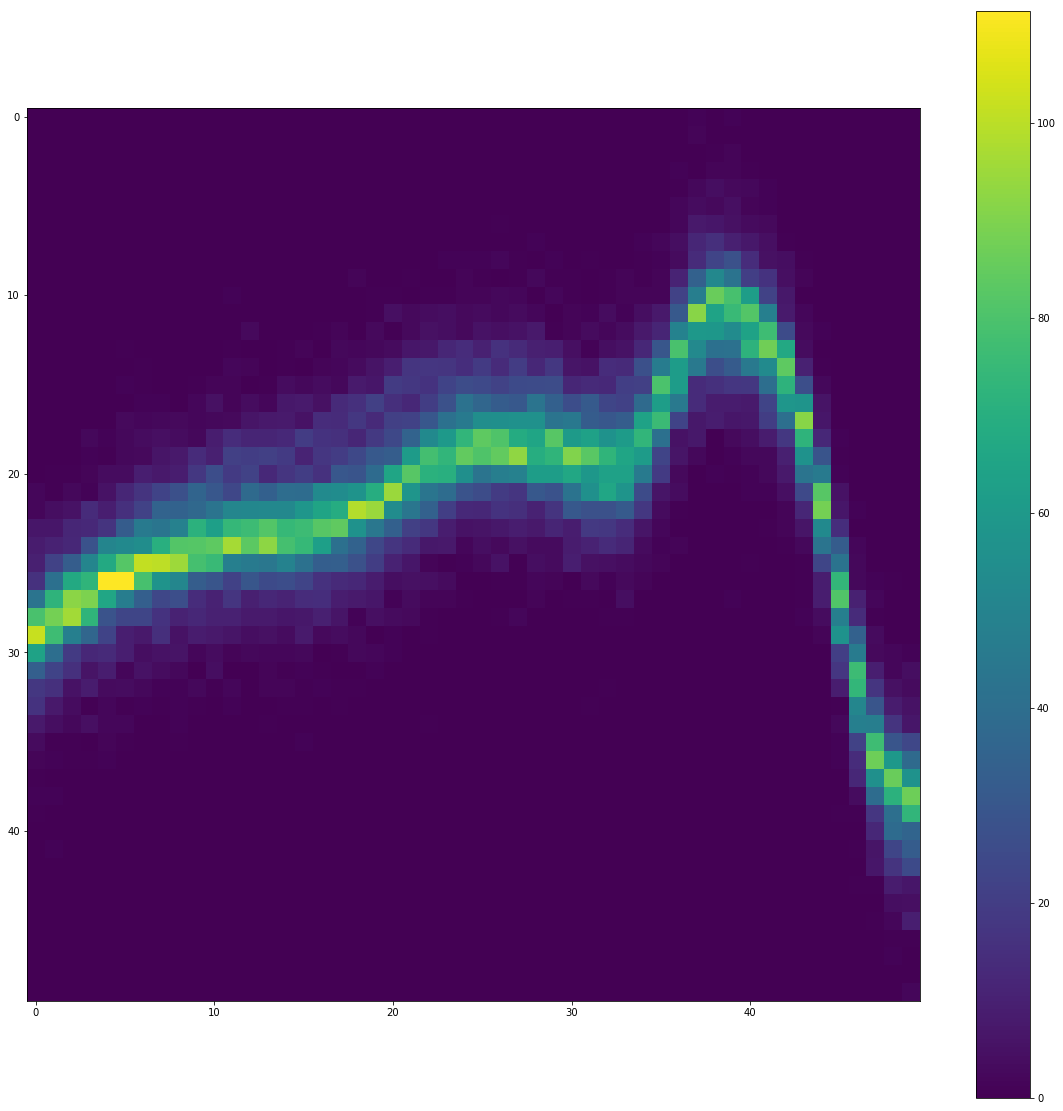

In [56]:
fig,ax = plt.subplots(figsize=(20,20))
print "Graphing Progress: ",
x_vals = []
y_vals = []
z_vals = []
for i in range(len(results)):
    for j in range(len(results[i])):
        x_vals.append(results[i][j])
        y_vals.append(frequency_range[j])
        z_vals.append(probabilities[i])
heatmap,xedges,yedges = np.histogram2d(x_vals,y_vals,weights=z_vals,bins=50)
extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap)
plt.colorbar()
plt.show()